# Fraud Detection Prediction

For any bank or financial organization,fraud detection is of utmost importance. We have to spot potential fraud so that consumers can not bill for goods that they haven’t purchased. The aim is, therefore, to create a classifier that indicates whether a requested transaction is a fraud.

### Statistical data analysis techniques include:

- calculating statistical parameters
- regression analysis
- probability distributions and models
- data matching

### AI techniques used to detect fraud include:

- Data mining classifies, groups and segments data to search through millions of transactions to find patterns and detect fraud.
- Neural networks learn suspicious-looking patterns and use those patterns to detect them further.
- Machine learning automatically identifies characteristics found in fraud.
- Pattern recognition detects classes, clusters and patterns of suspicious behavior.

### Setting up the evironment

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, precision_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve

pd.option_context('display.max_columns', None, 'display.precision', 3)

# 1. Raw data Collection and preprocessing

### Checking for missing/null values

In [69]:
data = pd.read_csv("Fraud.csv")
pd.isnull(data).any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [70]:
pd.isna(data).any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

### Dropping rows with type = DEBIT, PAYMENT, CASH_IN 
These columns on observation have been noticed to have significantly less impact and almost no correlation with the isFraud column.

In [95]:
#define values
values = ['DEBIT', 'PAYMENT', 'CASH_IN']

#drop rows that contain any value in the list
data = data[data.type.isin(values) == False]

#### Getting Dummy values for 'type' column

In [96]:
dummy_df2 = pd.get_dummies(data, columns=['type'], prefix=[""])

In [97]:
dummy_df2

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,_CASH_OUT,_TRANSFER
2,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,0,1
3,1,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,1,0
15,1,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0,1,0
19,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0,1
24,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,1,0
6362616,743,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,1,0
6362618,743,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,0,1


# 2. Feature Engineering

### Defining 'isFlaggedFraud' column

In [98]:
def fraudflag(x):
    if x>200000:
        return 1
    else:
        return 0

### Creating new columns 

1. OrgChange = newbalanceOrig - oldblanaceOrg
2. DestChange = newbalanceDest - oldbalanceDest

#### Also dropping 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest', 'nameOrig', 'nameDest' and defining correlation df

In [186]:
dummy_df2['isFlaggedFraud'] = dummy_df2['amount'].apply(lambda x: fraudflag(x))
dummy_df2['OrgChange'] = dummy_df2['newbalanceOrig'] - dummy_df2['oldbalanceOrg']  
dummy_df2['DestChange'] = dummy_df2['newbalanceDest'] - dummy_df2['oldbalanceDest']  
final_df2 = dummy_df2.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest', 'nameOrig', 'nameDest'])

In [187]:
final_df2_corr = final_df2.drop(columns=['_TRANSFER','_CASH_OUT','isFlaggedFraud','isFraud'])

In [188]:
cols = [c for c in final_df2.columns if c[-6:] == 'Change']
final_df2[cols] = final_df2[cols].apply(lambda x: abs(x))
final_df2.reset_index(inplace=True)

### Building Correlation matrix for non binary columns

<AxesSubplot:>

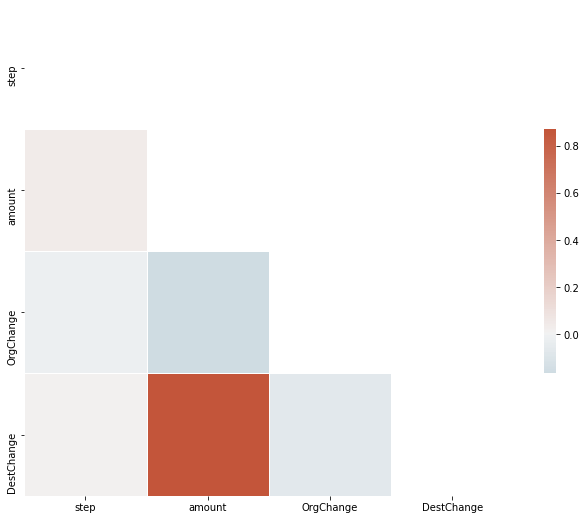

In [189]:
def corrX_orig(df, cut = 0.9) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()

        
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
    # If cell.value > 0.6: 
    # If mean(row_correlation) > mean(column_correlation):drop(column)
    # Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

corr = final_df2_corr.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [190]:
drop = corrX_orig(final_df2_corr, cut = 0.6)
print(drop)

['amount']


/var/folders/7v/5bjjg3ds57g4cvrlx_ny2qvr0000gp/T/ipykernel_1292/3795163042.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))


### Dropping columns 
Based on corrX_orig function decide cutoff we drop off the 'amount' column.  

In [191]:
final_df2.drop(columns=drop,inplace=True)
final_df2 = final_df2.iloc[:,1:]
final_df2

,step,isFraud,isFlaggedFraud,_CASH_OUT,_TRANSFER,OrgChange,DestChange
0,1,1,0,0,1,181.00,0.00
1,1,1,0,1,0,181.00,21182.00
2,1,0,1,1,0,15325.00,46430.44
3,1,0,1,0,1,705.00,22425.00
4,1,0,1,0,1,10835.00,2712905.89
...,...,...,...,...,...,...,...
2770404,743,1,1,1,0,339682.13,339682.13
2770405,743,1,1,0,1,6311409.28,0.00
2770406,743,1,1,1,0,6311409.28,6311409.27
2770407,743,1,1,0,1,850002.52,0.00


### Using Standard scaling Technique 

In [192]:
final_df2_binary = final_df2.drop(columns=['OrgChange','DestChange','step'])
final_df2_scalable = final_df2.drop(columns=['isFraud','isFlaggedFraud','_CASH_OUT','_TRANSFER'])

In [196]:
final_df2_binary

,isFraud,isFlaggedFraud,_CASH_OUT,_TRANSFER
0,1,0,0,1
1,1,0,1,0
2,0,1,1,0
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
2770404,1,1,1,0
2770405,1,1,0,1
2770406,1,1,1,0
2770407,1,1,0,1


In [195]:
final_df2_scalable

,step,OrgChange,DestChange
0,1,181.00,0.00
1,1,181.00,21182.00
2,1,15325.00,46430.44
3,1,705.00,22425.00
4,1,10835.00,2712905.89
...,...,...,...
2770404,743,339682.13,339682.13
2770405,743,6311409.28,0.00
2770406,743,6311409.28,6311409.27
2770407,743,850002.52,0.00


In [232]:
scaler = StandardScaler()
scaler.fit(final_df2_scalable)
final_df2_scaled = pd.DataFrame(scaler.transform(final_df2_scalable))
final_df2 = pd.concat([final_df2_binary, final_df2_scaled], axis=1)
final_df2.rename(columns={0:'step',1:'OrgChange',2:'DestChange'},inplace=True)

In [233]:
final_df2

,isFraud,isFlaggedFraud,_CASH_OUT,_TRANSFER,step,OrgChange,DestChange
0,1,0,0,1,-1.701805,-0.191519,-0.297938
1,1,0,1,0,-1.701805,-0.191519,-0.279934
2,0,1,1,0,-1.701805,-0.099063,-0.258473
3,0,1,0,1,-1.701805,-0.188320,-0.278878
4,0,1,0,1,-1.701805,-0.126475,2.007973
...,...,...,...,...,...,...,...
2770404,1,1,1,0,3.537602,1.881177,-0.009216
2770405,1,1,0,1,3.537602,38.339298,-0.297938
2770406,1,1,1,0,3.537602,38.339298,5.066623
2770407,1,1,0,1,3.537602,4.996745,-0.297938


# 3. Model Testing and Evaluation

Models used are:

- Logistic Regression with cross validation
- XG Boost
- K Neighbors
- Weighted Logistic Regression
- Gradient Boosting
- Logistic Regression with SMOTE

In [199]:
X = final_df2.drop(columns=['isFraud'], axis=1)
y = final_df2['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Checking our most important features

In [206]:
# coef = model.coef_[0]
# imp_features = pd.Series(X_train.columns)[list(coef!=0)]
# imp_features

## Logistic Regression with cross validation

In [215]:
model = LogisticRegressionCV(cv=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.89      0.52      0.66      2051

    accuracy                           1.00    692603
   macro avg       0.94      0.76      0.83    692603
weighted avg       1.00      1.00      1.00    692603



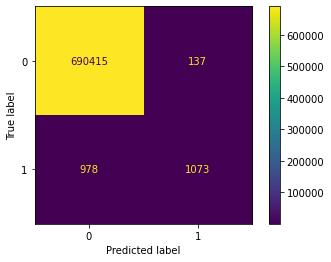

In [216]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

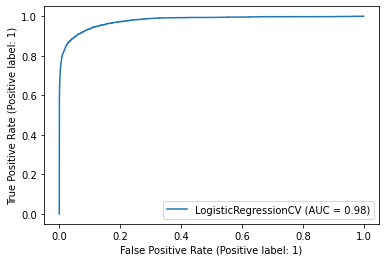

In [217]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## XG Boost

In [218]:
from numpy import loadtxt
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/Users/Abhinav/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.98      0.81      0.88      2051

    accuracy                           1.00    692603
   macro avg       0.99      0.90      0.94    692603
weighted avg       1.00      1.00      1.00    692603



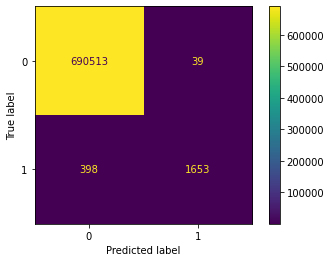

In [219]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

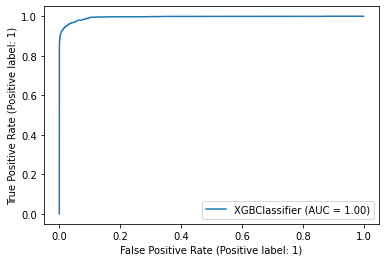

In [220]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## K Neighbors 

In [229]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.95      0.67      0.79      2051

    accuracy                           1.00    692603
   macro avg       0.97      0.84      0.89    692603
weighted avg       1.00      1.00      1.00    692603



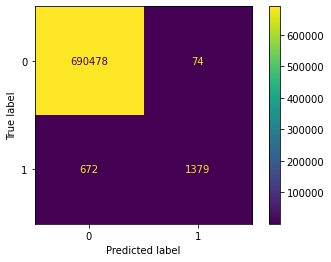

In [230]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

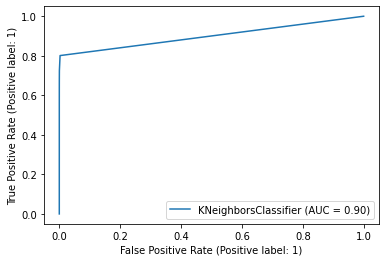

In [231]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Weighted Logistic Regression

In [207]:
# define class weights
w = {0:1, 1:99}

# define model
lg2 = LogisticRegression(class_weight=w)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred = lg2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    690552
           1       0.12      0.83      0.22      2051

    accuracy                           0.98    692603
   macro avg       0.56      0.91      0.60    692603
weighted avg       1.00      0.98      0.99    692603



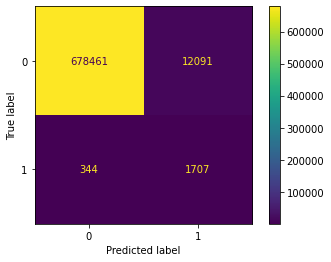

In [208]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

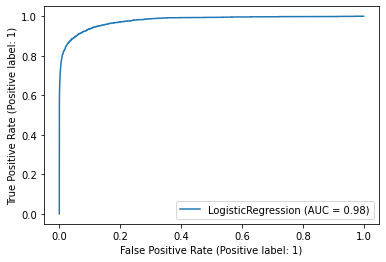

In [209]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Gradient Boosting

In [223]:
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in lr_list:
    model = GradientBoostingClassifier(learning_rate=learning_rate, random_state=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.96      0.73      0.83      2051

    accuracy                           1.00    692603
   macro avg       0.98      0.86      0.91    692603
weighted avg       1.00      1.00      1.00    692603

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.90      0.71      0.79      2051

    accuracy                           1.00    692603
   macro avg       0.95      0.85      0.90    692603
weighted avg       1.00      1.00      1.00    692603

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690552
           1       0.97      0.73      0.83      2051

    accuracy                           1.00    692603
   macro avg       0.98      0.87      0.92    692603
weighted avg       1.00      1.00      1.00    692603

              preci

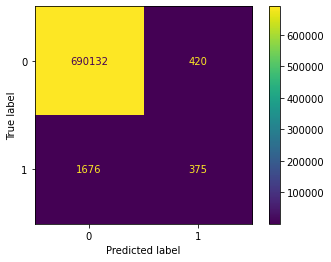

In [224]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

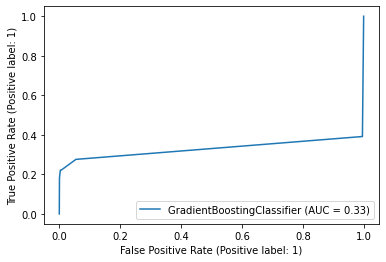

In [225]:
plot_roc_curve(model, X_test, y_test)
plt.show()

## Logistic Regression with SMOTE 

Due to high imbalance between majority class and minority class, we try applying SMOTE by oversampling the minority class. In our case, the minority class is True fraudulent transactions.

In [210]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

X_train_new = pd.DataFrame(X_train_new)
X_train_new.columns = X_train.columns
y_train_new = pd.DataFrame(y_train_new)

print('After OverSampling, the shape of X_train_new: {}'.format(X_train_new.shape))
print('After OverSampling, the shape of y_train_new: {} \n'.format(y_train_new.shape))

Before OverSampling, counts of label '1': 6162
Before OverSampling, counts of label '0': 2071644 

After OverSampling, the shape of X_train_new: (4143288, 6)
After OverSampling, the shape of y_train_new: (4143288, 1) 



In [211]:
model = LogisticRegression()
model.fit(X_train_new, np.ravel(y_train_new))
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    690552
           1       0.04      0.93      0.08      2051

    accuracy                           0.94    692603
   macro avg       0.52      0.93      0.53    692603
weighted avg       1.00      0.94      0.97    692603



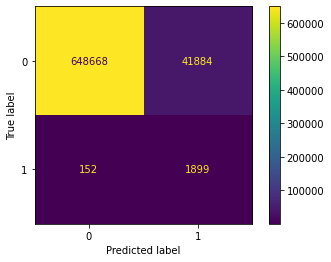

In [212]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

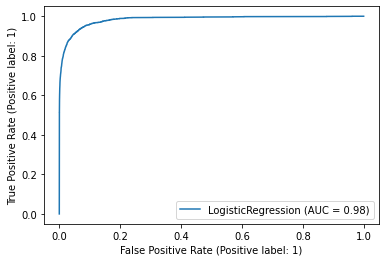

In [213]:
plot_roc_curve(model, X_test, y_test)
plt.show()

#### Ideally for choosing a model for our business problem, a model with high precision and low recall would be recommended. 
 After evaluating the accuracy, f1-score and confusion matrix of each model, we can see that the XG Boost model is has higher score in each category. Looking at the XG Boost confusion matrix we can see that the model has done a very good job classifying the fraudulent transactions.
 
 Thus we have succeefully built six types of classification models and after evaluating each model, we can conclude that the XG Boost model is the best model for our use case.